In [1]:
import h5py
import zipfile 
import cv2 as cv
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download data

In [4]:
import zipfile
with zipfile.ZipFile('./calo.zip', 'r') as zip_ref:
  zip_ref.extractall('./')

In [3]:
positron_data = h5py.File('./calo/eplus.hdf5', 'r')
pos_group_key = list(positron_data.keys())[3]
positron_second_layer_data = list(positron_data[pos_group_key])

In [4]:
pion_data = h5py.File('./calo/piplus.hdf5', 'r')
pion_group_key = list(pion_data.keys())[3]
pion_second_layer_data = list(pion_data[pos_group_key])

## Observe data

In [5]:
len(positron_second_layer_data)

100000

In [6]:
len(pion_second_layer_data)

100000

In [7]:
positron_second_layer_data[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.78315792, 0.        ,
        0.        ],
       [0.        , 0.82805987, 0.        , 0.3559833 , 0.        ,
        0.        ],
       [0.        , 0.36701843, 0.9486245 , 5.52563904, 4.96058018,
        0.        ],
       [0.        , 0.51099891, 3.75894563, 5.65895993, 2.23624359,
        0.        ],
       [2.43694855, 0.        , 0.54972165, 7.96625306, 1.57433178,
        1.4580423 ],
       [0.        , 1.8229943 , 6.78788657, 1.19695026, 0.        ,
        0.        ],
       [0.49139271, 0.11455069, 4.52358156, 7.246226  , 6.68257787,
        0.        ],
       [0.        , 0.        , 0.        , 0.88070482, 0.        ,
        1.64540192],
       [0.        , 0.        , 0.        , 1.57348787, 0.        ,
        0.        ],
       [0.        , 0

In [8]:
maximums_positron = [0]*len(positron_second_layer_data)
for ind, img in enumerate(positron_second_layer_data):
  maximums_positron[ind] = img.max()

maximums_pion = [0]*len(pion_second_layer_data)
for ind, img in enumerate(pion_second_layer_data):
  maximums_pion[ind] = img.max()

print(max(maximums_positron))
print(max(maximums_pion))

1402.8536887319758
13149.016304413419


(-0.5, 5.5, 11.5, -0.5)

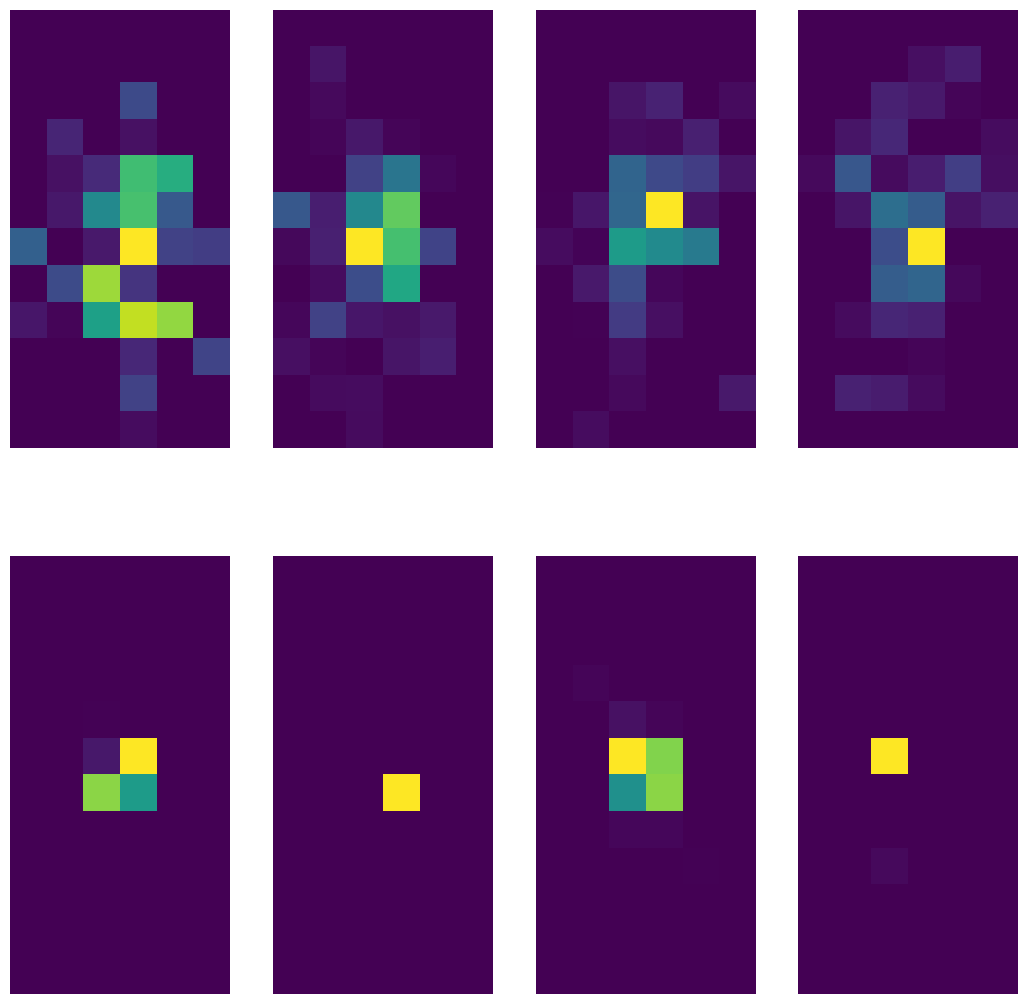

In [9]:
plt.figure(figsize=(13, 13))
plt.tight_layout()
plt.subplot(2,4,1)
plt.imshow(positron_second_layer_data[0])
plt.axis('off') 
plt.subplot(2,4,2)
plt.imshow(positron_second_layer_data[1])
plt.axis('off') 
plt.subplot(2,4,3)
plt.imshow(positron_second_layer_data[2])
plt.axis('off') 
plt.subplot(2,4,4)
plt.imshow(positron_second_layer_data[3])
plt.axis('off') 

plt.subplot(2,4,5)
plt.imshow(pion_second_layer_data[0])
plt.axis('off') 
plt.subplot(2,4,6)
plt.imshow(pion_second_layer_data[1])
plt.axis('off') 
plt.subplot(2,4,7)
plt.imshow(pion_second_layer_data[2])
plt.axis('off') 
plt.subplot(2,4,8)
plt.imshow(pion_second_layer_data[3])
plt.axis('off') 

In [10]:
def outer_sum(img):
  img_masked = img.copy()
  img_masked[5:7, 2:4] = 0

  return np.sum(img_masked)

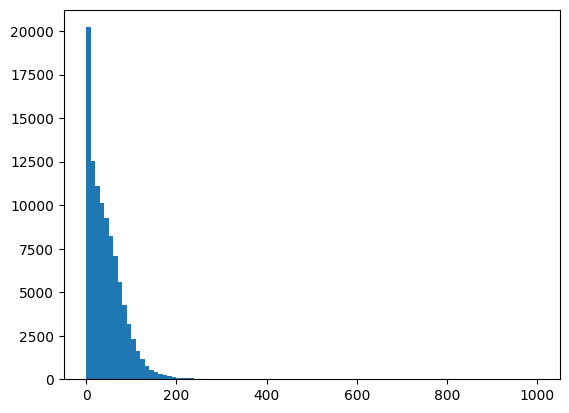

In [11]:
outer_sums_positron = [0]*len(positron_second_layer_data)
for ind, img in enumerate(positron_second_layer_data):
  outer_sums_positron[ind] = outer_sum(img)

plt.hist(outer_sums_positron, range = (0,1000), bins = 100);

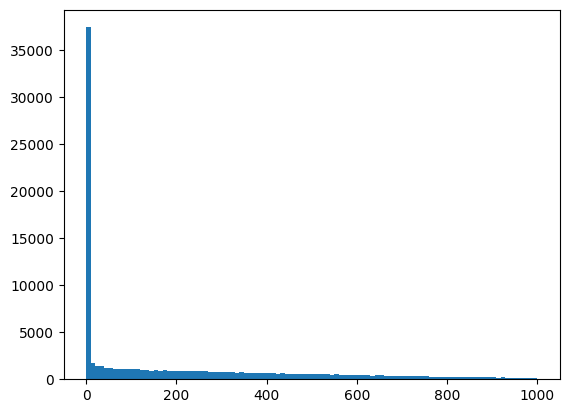

In [12]:
outer_sums_pion = [0]*len(pion_second_layer_data)
for ind, img in enumerate(pion_second_layer_data):
  outer_sums_pion[ind] = outer_sum(img)

plt.hist(outer_sums_pion, range = (0,1000), bins = 100);
ax = plt.gca()

In [13]:
def nonzero_outer_elements(img):
  img_masked = img.copy()
  img_masked[5:7, 2:4] = 0

  return np.sum(img_masked != 0)

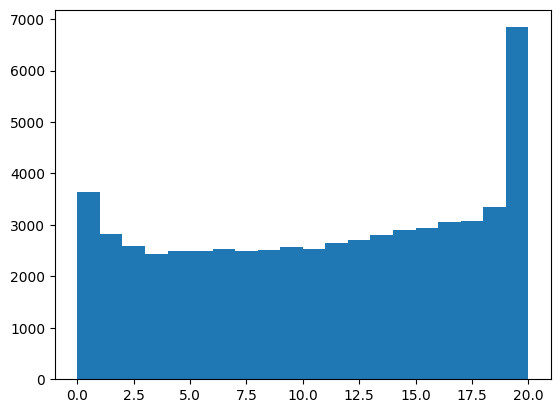

In [14]:
outer_nonzero_positron = [0]*len(positron_second_layer_data)
for ind, img in enumerate(positron_second_layer_data):
  outer_nonzero_positron[ind] = nonzero_outer_elements(img)

plt.hist(outer_nonzero_positron, range = (0,20), bins = 20);
ax = plt.gca()

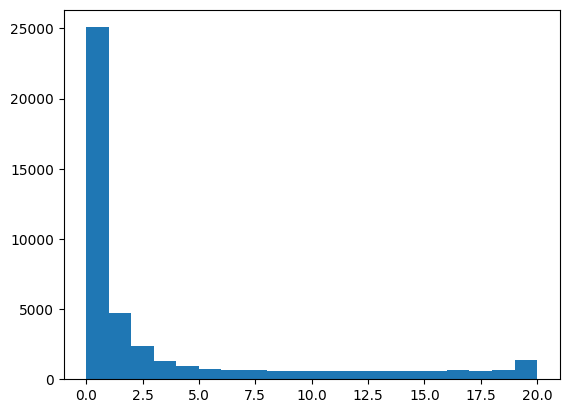

In [15]:
outer_nonzero_pion = [0]*len(pion_second_layer_data)
for ind, img in enumerate(pion_second_layer_data):
  outer_nonzero_pion[ind] = nonzero_outer_elements(img)

plt.hist(outer_nonzero_pion, range = (0,20), bins = 20);
ax = plt.gca()

## Converting to [0,255] (May be not needed)

In [16]:
def to_img(h5_img):
  img = h5_img
  np.clip(img, 0, 8000, out = img)
  img *= 255
  img /= 8000

  return img

In [17]:
def data_to_imgs(data):
  data_imgs = [None]*len(data)
  for ind, h5_img in enumerate(data):
    data_imgs[ind] = to_img(h5_img)

  return data_imgs

In [18]:
positron_second_layer_imgs = data_to_imgs(positron_second_layer_data)
pion_second_layer_imgs = data_to_imgs(pion_second_layer_data)

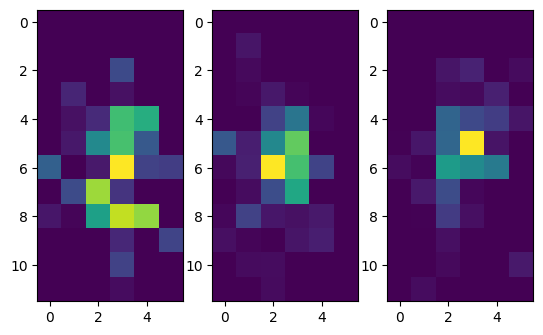

In [19]:
plt.subplot(1,3,1)
plt.imshow(positron_second_layer_imgs[0])
plt.subplot(1,3,2)
plt.imshow(positron_second_layer_imgs[1])
plt.subplot(1,3,3)
plt.imshow(positron_second_layer_imgs[2])

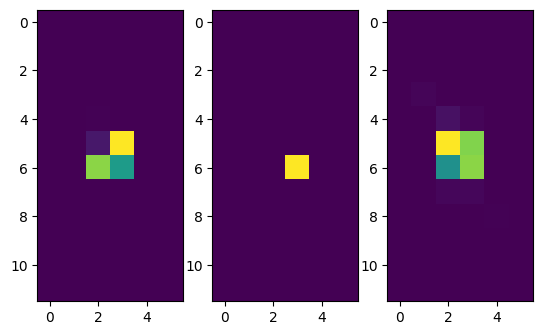

In [20]:
plt.subplot(1,3,1)
plt.imshow(pion_second_layer_imgs[0])
plt.subplot(1,3,2)
plt.imshow(pion_second_layer_imgs[1])
plt.subplot(1,3,3)
plt.imshow(pion_second_layer_imgs[2])

## Train-test split

In [21]:
positron_tags = [0]*len(positron_second_layer_data)
pion_tags = [1]*len(pion_second_layer_data)

train_data, test_data, train_tags, test_tags = train_test_split(positron_second_layer_data + pion_second_layer_data, positron_tags + pion_tags, test_size = 0.2, random_state = 42)

## Evaluation of simple methods

In [22]:
def evaluate(classifier):
  predictions = [0] * len(test_data)
  for ind, img in enumerate(test_data):
    predictions[ind] = classifier(img)
  accuracy = accuracy_score(test_tags, predictions)
  roc_score = roc_auc_score(test_tags, predictions)
  conf_matr = confusion_matrix(test_tags, predictions) / len(test_data)

  return accuracy, roc_score, conf_matr

In [25]:
def evaluate_normalized(classifier):
  test_data_normalized = data_to_imgs(test_data)
  predictions = [0] * len(test_data_normalized)
  for ind, img in enumerate(test_data_normalized):
    predictions[ind] = classifier(img)
  accuracy = accuracy_score(test_tags, predictions)
  roc_score = roc_auc_score(test_tags, predictions)
  conf_matr = confusion_matrix(test_tags, predictions) / len(test_data)

  return accuracy, roc_score, conf_matr

In [26]:
def base_classifier(img):
  return random.choice([0,1])

In [27]:
base_accuracy, base_roc, base_conf_matrix = evaluate(base_classifier)
print("Accuracy:", base_accuracy, "\nRoc:", base_roc, "\nConfusion matrix:\n", base_conf_matrix)

Accuracy: 0.497425 
Roc: 0.49742545468461824 
Confusion matrix:
 [[0.249275 0.25055 ]
 [0.252025 0.24815 ]]


In [28]:
def outer_sum_classifier(img):
  sum = outer_sum(img)

  if sum < 10:
    return 1
  else:
    return 0

In [29]:
outer_sum_accuracy, outer_sum_roc, outer_sum_conf_matrix = evaluate(outer_sum_classifier)
print("Accuracy:", outer_sum_accuracy, "\nRoc:", outer_sum_roc, "\nConfusion matrix:\n", outer_sum_conf_matrix)

Accuracy: 0.3435 
Roc: 0.34338011456406403 
Confusion matrix:
 [[4.25000e-04 4.99400e-01]
 [1.57100e-01 3.43075e-01]]


In [30]:
def outer_nonzero_classifier(img):
  outer_nonzero = nonzero_outer_elements(img)
  if outer_nonzero > 1:
    return 0
  else:
    return 1

In [31]:
outer_nonzero_accuracy, outer_nonzero_roc, outer_nonzero_conf_matrix = evaluate(outer_nonzero_classifier)
print("Accuracy:", outer_nonzero_accuracy, "\nRoc:", outer_nonzero_roc, "\nConfusion matrix:\n", outer_nonzero_conf_matrix)

Accuracy: 0.6171 
Roc: 0.6172107631083185 
Confusion matrix:
 [[0.466675 0.03315 ]
 [0.34975  0.150425]]


## Catboost

In [29]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import catboost as ctb

train_size = len(train_data)
vectorized_train_data = np.zeros((train_size, 72))

for ind, img in enumerate(train_data):
  img_vec = img.reshape(1, 72)
  vectorized_train_data[ind, :] = img_vec

cbc = ctb.CatBoostClassifier()
cbc.fit(vectorized_train_data, train_tags, verbose = 1)

Learning rate set to 0.089969
0:	learn: 0.6081042	total: 315ms	remaining: 5m 14s
1:	learn: 0.5396022	total: 565ms	remaining: 4m 42s
2:	learn: 0.4860972	total: 796ms	remaining: 4m 24s
3:	learn: 0.4423636	total: 1.05s	remaining: 4m 20s
4:	learn: 0.4083796	total: 1.16s	remaining: 3m 51s
5:	learn: 0.3797328	total: 1.33s	remaining: 3m 40s
6:	learn: 0.3575860	total: 1.64s	remaining: 3m 53s
7:	learn: 0.3386788	total: 1.84s	remaining: 3m 48s
8:	learn: 0.3210371	total: 2.04s	remaining: 3m 45s
9:	learn: 0.3056414	total: 2.27s	remaining: 3m 44s
10:	learn: 0.2910424	total: 2.51s	remaining: 3m 45s
11:	learn: 0.2794950	total: 2.72s	remaining: 3m 43s
12:	learn: 0.2689986	total: 2.92s	remaining: 3m 41s
13:	learn: 0.2600986	total: 3.1s	remaining: 3m 38s
14:	learn: 0.2499800	total: 3.31s	remaining: 3m 37s
15:	learn: 0.2425893	total: 3.5s	remaining: 3m 35s
16:	learn: 0.2354320	total: 3.7s	remaining: 3m 34s
17:	learn: 0.2290997	total: 3.9s	remaining: 3m 32s
18:	learn: 0.2225403	total: 4.11s	remaining: 3m 

In [31]:
test_size = len(test_data)
vectorized_test_data = np.zeros((test_size, 72))

for ind, img in enumerate(test_data):
  img_vec = img.reshape(1, 72)
  vectorized_test_data[ind, :] = img_vec

predictions = cbc.predict(vectorized_test_data)

0.985275

In [78]:
cb_accuracy = accuracy_score(test_tags, predictions)
cb_roc = roc_auc_score(test_tags, predictions)
cb_conf_matrix = confusion_matrix(test_tags, predictions) / len(test_data)

print("Accuracy:", cb_accuracy, "\nRoc:", cb_roc, "\nConfusion matrix:\n", cb_conf_matrix)

Accuracy: 0.985275 
Roc: 0.9852775269464971 
Confusion matrix:
 [[0.496075 0.00375 ]
 [0.010975 0.4892  ]]


Predicted: 1 True: 1
Predicted: 0 True: 0
Predicted: 1 True: 1
Predicted: 0 True: 0
Predicted: 0 True: 0
Predicted: 0 True: 0
Predicted: 1 True: 1
Predicted: 1 True: 1
Predicted: 1 True: 1
Predicted: 0 True: 0


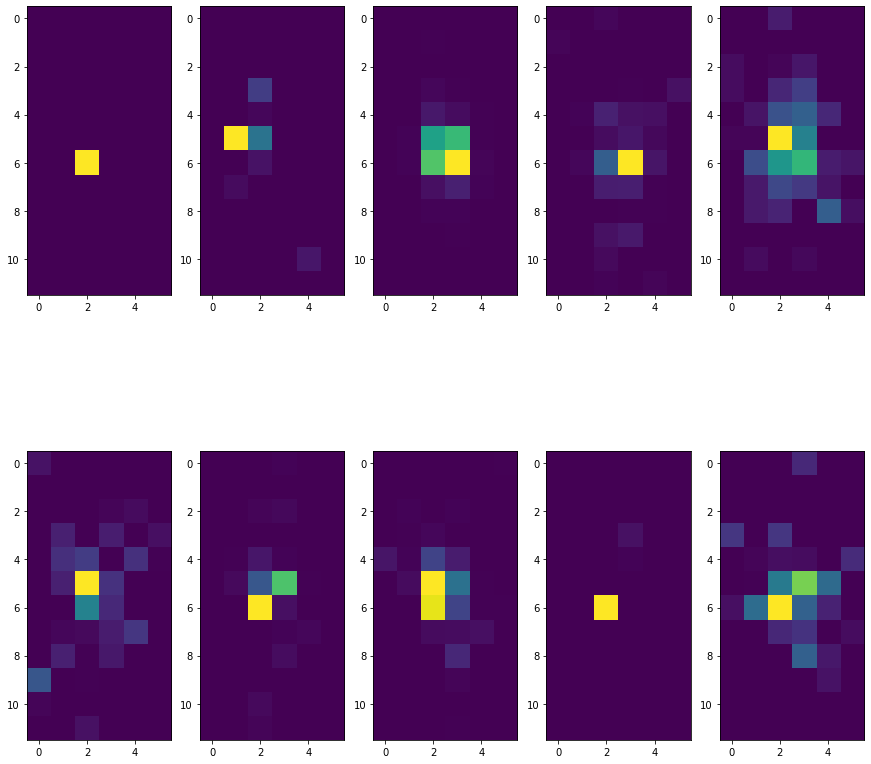

In [55]:
plt.figure(figsize=(15, 15))

for ind in range(10):
  
  plt.subplot(2, 5,ind + 1)
  plt.imshow(test_data[ind])
  print("Predicted:", predictions[ind], "True:", test_tags[ind])

# TEMPLATE MATCHING

In [59]:
template1 = np.zeros((4,4))
template2 = np.zeros((4,4))
numer_of_imgs = 90

for i in range(numer_of_imgs):
    template1 += positron_second_layer_imgs[i][4:8, 1:5]
template_pos = np.float32(template1 / numer_of_imgs)

for i in range(numer_of_imgs):
    template2 += pion_second_layer_imgs[i][4:8, 1:5]
template_pion = np.float32(template2 / numer_of_imgs)

def template_match_classification(img):
    img = np.float32(img)
    tableHitPos = cv.matchTemplate(template_pos, img, method=cv.TM_CCOEFF_NORMED)
    tableHitPion = cv.matchTemplate(template_pion, img, method=cv.TM_CCOEFF_NORMED)
    (min_valPos, max_valPos, minLocPos, maxLocPos) = cv.minMaxLoc(tableHitPos)
    (min_valPion, max_valPion, minLocPion, maxLocPion) = cv.minMaxLoc(tableHitPion)
    if max_valPos > max_valPion:
        return 1
    else:
        return 0
evaluate_normalized(template_match_classification)

(0.53235,
 0.5323064202075365,
 array([[0.203825, 0.296   ],
        [0.17165 , 0.328525]]))